# Generic equivalent layer applied to magnetic data

### Brief description

This Jupyter notebook is a supplementary material contaning the code needed to generate part of the synthetic data and reproduce part of the figures and results of this course. This code uses the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/index.html).

This code presents the application of an undulating equivalent layer formed by point masses with the purpose of processing total-field anomaly data. The estimated equivalent layer is saved as a pickle file in `results`.

**Note:** A Jupyter notebook is a document that incorporates text, results, figures, and the Python source code to produce them. If you are viewing this from the URL https://nbviewer.jupyter.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install all the required dependencies. For installing the Fatiando a Terra and all the required dependencies, please follow the instructions shown in http://www.fatiando.org/install.html.

### Import the required dependencies

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af

from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular

#from fatiando.gravmag import prism, sphere
from fatiando.gravmag import _prism_numpy as prism
from fatiando.gravmag import _sphere_numpy as sphere

#from fatiando.gravmag.eqlayer import EQLGravity
from fatiando.gravmag._eqlayer_numpy import EQLGravity

from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate
from fatiando.constants import G, SI2MGAL, SI2EOTVOS

In [2]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['xtick.major.pad'] = 3
plt.rcParams['ytick.major.pad'] = 3

In [3]:
notebook_name = 'generic_eqlayer_mag.ipynb'

In [4]:
saved_files = [] #list of saved files

### Load the synthetic model formed by two rectangular prisms

In [5]:
with open('results\\model.pickle') as f:
        full_model = pickle.load(f)

In [6]:
inc, dec = full_model['geomag_field']

In [7]:
ints, incs, decs = vec2ang(full_model['model'][0].props['magnetization'])

In [8]:
rhos = full_model['model'][0].props['density']

### Load the grid of points

In [9]:
with open('results\\airborne_survey.pickle') as f:
        grid = pickle.load(f)

In [10]:
grid

{'DS': 260793.97276151844,
 'N': 3600,
 'area': [0, 30000, 5000, 35000],
 'metadata': 'Generated by computation_points.ipynb on 24 October 2016 01:15:20 UTC',
 'shape': (120, 30),
 'spacing': [252.10084033613447, 1034.4827586206898]}

### Define the coordinates on the observation surface

In [11]:
#coordinates x and y of the data
xp, yp = regular(grid['area'], grid['shape'])

#vertical coordinates of the data
zp = af.observation_surface(xp,yp)

### Observed total-field anomaly

Total-field anomaly (equation 8) produced by the synthetic prisms (Figure 3) at the `airborne_survey` points on the undulating surface (Figure 4a). This anomaly is contaminated with a pseudo-random Gaussian noise having null mean and standard deviation equal to $5$ nT.

In [12]:
tf_noise = 5.

In [13]:
tf = contaminate(prism.tf(xp,yp,zp,full_model['model'], inc, dec), tf_noise, seed=47)

### True total gradient amplitude

Noise-free total-gradient amplitude produced by the synthetic prisms (Figure 3) at the `airborne_survey` points on the undulating surface (Figure 4a). The total-field amplitude was calculated by using equation 8 and a central finite difference approximation with constant spacing `delta`.

In [14]:
delta = 5.

In [15]:
dxtf = (prism.tf(xp+delta,yp,zp,full_model['model'],inc,dec) - \
        prism.tf(xp-delta,yp,zp,full_model['model'],inc,dec))/(2.*delta)

dytf = (prism.tf(xp,yp+delta,zp,full_model['model'],inc,dec) - \
        prism.tf(xp,yp-delta,zp,full_model['model'],inc,dec))/(2.*delta)

dztf = (prism.tf(xp,yp,zp+delta,full_model['model'],inc,dec) - \
        prism.tf(xp,yp,zp-delta,full_model['model'],inc,dec))/(2.*delta)

In [16]:
tga = np.sqrt(dxtf**2. + dytf**2. + dztf**2.)

### Undulating equivalent layer

#### Parameters defining the equivalent layer

In [17]:
#undulating surface containing the equivalent sources

h = 1200.
z0 = zp + h

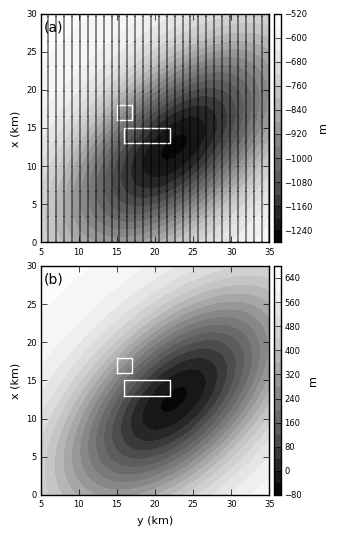

In [18]:
file_name = 'figs\\Fig10'

nplots = 2

f, (ax1, ax2) = plt.subplots(nplots,figsize=(3.33333,nplots*2.66667))

af.multiplotmap(ax1, xp, yp, zp, grid['shape'], grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'm',
                figure_label = '(a)', label_x = False,
                observations=True, point_style='.k', point_size=1)

af.multiplotmap(ax2, xp, yp, z0, grid['shape'], grid['area'],
                color_scheme = 'Greys_r', prism_projection = True, projection_style = '-w', 
                model = full_model['projection'], unit = 'm', 
                figure_label = '(b)')

plt.savefig(file_name+'.png', dpi=600)
saved_files.append(file_name+'.png')

plt.show()

In [19]:
caption = "(a) Undulating observation surface where we calculate the total-field anomaly (Figure 11a) and the total-gradient \
amplitude (Figure 11d) produced by the simulated prisms (Figure 3). These magnetic data are calculated at a regular \
grid of %d $\\times$ %d points (black dots) in the $x$ and $y$ directions. \
(b) Undulating surface (grayscale) defining an uneven equivalent layer. \
The white rectangles represent the horizontal projection of the simulated prisms \
(Figure 3)." \
% (grid['shape'][0], grid['shape'][1])

In [20]:
dp(md(caption))

(a) Undulating observation surface where we calculate the total-field anomaly (Figure 11a) and the total-gradient amplitude (Figure 11d) produced by the simulated prisms (Figure 3). These magnetic data are calculated at a regular grid of 120 $\times$ 30 points (black dots) in the $x$ and $y$ directions. (b) Undulating surface (grayscale) defining an uneven equivalent layer. The white rectangles represent the horizontal projection of the simulated prisms (Figure 3).

#### Estimated physical-property distribution

Linear inverse problem for estimating the physical property distribution within the equivalent layer. A previously estimated equivalent layer may be saved at the directory `results` as a pickle file named `inversion_notebookname.pickle`. Execute the cell below to check if this file exists. If this file does not exist, an IOError will be raised. In this case, you will need to run the inversion. To do this, you need first transform the following 17 cells from `Raw NBConvert` to `Code` and execute them.

In [21]:
file_name = 'results\\inversion_%s.pickle' % notebook_name[:st.index(notebook_name,'.')]
with open(file_name) as f:
    inversion = pickle.load(f)

layer = inversion['layer']
predicted = inversion['predicted']
estimate = inversion['estimate']

residuals = predicted - tf

print inversion['metadata']

Generated by generic_eqlayer_mag.ipynb on 25 May 2016 22:00:02 UTC


#### Save the results

#### Data fit

#### Comparison between the true and predicted total-gradient amplitude

In [22]:
# horizontal derivatives
aux = SI2MGAL/SI2EOTVOS
dxtf_pred = sphere.gxz(xp, yp, zp, layer)*aux
dytf_pred = sphere.gyz(xp, yp, zp, layer)*aux
dztf_pred = sphere.gzz(xp, yp, zp, layer)*aux

In [23]:
# predicted total-gradient amplitude
tga_pred = np.sqrt(dxtf_pred**2. + dytf_pred**2. + dztf_pred**2.)

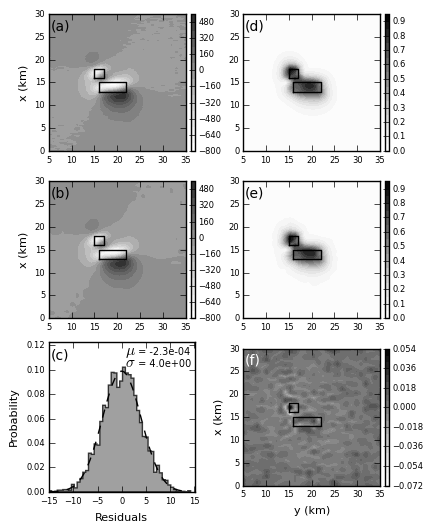

In [24]:
file_name = 'figs\\Fig11'

f, ax = plt.subplots(3,2,figsize=(4.33333,2*2.66667))

af.multiplotmap(ax[0][0], xp, yp, tf, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(tf, div=True),
                figure_label = '(a)', label_position = (0.02,0.89), label_x = False)

af.multiplotmap(ax[1][0], xp, yp, predicted, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(tf, div=True),
                figure_label = '(b)', label_position = (0.02,0.89), label_x = False)

af.multiplothist(ax[2][0], residuals, text_position = [0.52, 0.92, 0.84, 0.07],
                 text_fontsize = 7,
                 figure_label = '(c)', label_position = (0.02,0.89))

af.multiplotmap(ax[0][1], xp, yp, tga, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], 
                figure_label = '(d)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[1][1], xp, yp, tga_pred, grid['shape'], grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], 
                figure_label = '(e)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[2][1], xp, yp, tga_pred - tga, grid['shape'], grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'],
                figure_label = '(f)', label_color = 'w',
                label_position = (0.02,0.89))

plt.tight_layout()

plt.savefig(file_name+'.png', dpi=600)
saved_files.append(file_name+'.png')

plt.show()

In [25]:
caption = "(a) Total-field anomaly produced by the simulated prisms (Figure 3) and contaminated with a Gaussian \
noise having null mean and standard deviation equal to %.1f nT. \
(b) Total-field anomaly produced by the equivalent layer defined on the undulating surface shown in Figure 10b. \
Both data are given in nT. \
(c) Histogram of the residuals defined as the difference \
between the total-field anomalies shown in b and a. The black-dashed line represent \
a best fit Gaussian curve. The estimated mean and standard deviation are represented by $\mu$ and $\sigma$, \
respectively. \
(d) True total-gradient amplitude (noise-free) produced by the simulated prisms (Figure 3). \
(e) Total-gradient amplitude produced by the equivalent layer defined on the uneven surface \
shown in Figure 10b. Both data are given in nT/m. \
(f) Difference between the total-gradient amplitudes shown in e and d. \
All data are calculated at a regular grid of $%d \\times %d$ points represented as black dots in Figure 10a. \
The black rectangles represent the horizontal projection of the simulated \
prisms (Figure 3)." \
% (tf_noise, grid['shape'][0], grid['shape'][1])

In [26]:
dp(md(caption))

(a) Total-field anomaly produced by the simulated prisms (Figure 3) and contaminated with a Gaussian noise having null mean and standard deviation equal to 5.0 nT. (b) Total-field anomaly produced by the equivalent layer defined on the undulating surface shown in Figure 10b. Both data are given in nT. (c) Histogram of the residuals defined as the difference between the total-field anomalies shown in b and a. The black-dashed line represent a best fit Gaussian curve. The estimated mean and standard deviation are represented by $\mu$ and $\sigma$, respectively. (d) True total-gradient amplitude (noise-free) produced by the simulated prisms (Figure 3). (e) Total-gradient amplitude produced by the equivalent layer defined on the uneven surface shown in Figure 10b. Both data are given in nT/m. (f) Difference between the total-gradient amplitudes shown in e and d. All data are calculated at a regular grid of $120 \times 30$ points represented as black dots in Figure 10a. The black rectangles represent the horizontal projection of the simulated prisms (Figure 3).

### Saved files

In [27]:
with open('reports\\report_%s.md' % notebook_name[:st.index(notebook_name,'.')], 'w') as f:
    f.write('# Saved files \n')
    f.write('\n\n'+inversion['metadata']+'\n\n')
    f.write('*  `results\\inversion_%s.pickle`' % notebook_name[:st.index(notebook_name,'.')])
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = '\nGenerated by {name} on {date}'.format(date=now, name=notebook_name)
    f.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        f.write('*  `%s` \n' % (sf))

1  figs\Fig10.png
2  figs\Fig11.png
